In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### GET REPOSITORY ###
%%capture
!rm -r IncidentsDataset # Delete repo if already exists
!git clone https://github.com/sebastiancelis98/IncidentsDataset.git --branch data_science_project

In [ ]:
### GET PRETRAINED WEIGHTS ###
%%capture
!unzip drive/MyDrive/vit_b_20_epochs.zip -d IncidentsDataset/pretrained_weights/

In [ ]:
### INSTALL DEPENDENCIES ###
%%capture
!pip install wget
!pip install timm
!pip install tensorflow
!pip install -r IncidentsDataset/requirements.txt
!pip install protobuf==3.20.*
!pip install -U scikit-learn

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%capture
### IMPORTING LIBRARIES ###
import wget
import timm
import tensorflow as tf
import os
import pprint
import glob
import json
from tqdm import tqdm
import cv2
import torch
from PIL import Image

from IncidentsDataset.architectures import (
    FilenameDataset,
    get_incidents_model,
    update_incidents_model_with_checkpoint,
    update_incidents_model_to_eval_mode,
    get_predictions_from_model
)
from IncidentsDataset.parser import get_parser, get_postprocessed_args
from IncidentsDataset.utils import get_index_to_incident_mapping, get_index_to_place_mapping

In [ ]:
### GET EXAMPLE IMAGES ###
image_filenames = sorted(glob.glob("IncidentsDataset/example_images/*"))

In [ ]:
### GET MODEL ###
CONFIG_FILENAME = "IncidentsDataset/configs/vit_config"
CHECKPOINT_PATH_FOLDER = "IncidentsDataset/pretrained_weights/"
parser = get_parser()
args = parser.parse_args(args="--config={} --checkpoint_path={} --mode=test".format(CONFIG_FILENAME, CHECKPOINT_PATH_FOLDER))
args = get_postprocessed_args(args)

model = get_incidents_model(args)
update_incidents_model_with_checkpoint(model, args)
update_incidents_model_to_eval_mode(model)

Pre-trained weights not found. Downloading...
https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz
**** Loaded ViT pre-trained ****
Trainable block:  Linear(in_features=768, out_features=1024, bias=True)
**** Model loaded and freezed, except last layer ****
Let's use 1 GPUs!
Loaded checkpoint 'IncidentsDataset/pretrained_weights/trunk_best.pth.tar' (epoch 18).
Loaded checkpoint 'IncidentsDataset/pretrained_weights/place_best.pth.tar' (epoch 18).
Loaded checkpoint 'IncidentsDataset/pretrained_weights/incident_best.pth.tar' (epoch 18).
Switching to eval mode.


In [ ]:
### SETUP DATA LOADER ###
print("num images: {}".format(len(image_filenames)))
targets = [image_filenames[i] for i in range(len(image_filenames))]
dataset = FilenameDataset(image_filenames, targets)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2)

num images: 4


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
### RUN INFERENCE ###
inference_dict = {}
for idx, (batch_input, image_paths) in tqdm(enumerate(loader)):
    # run the model, get the output, set the inference_dict
    output = get_predictions_from_model(
        args,
        model,
        batch_input,
        image_paths,
        get_index_to_incident_mapping(),
        get_index_to_place_mapping(),
        inference_dict,
        topk=5
    )

4it [00:06,  1.67s/it]


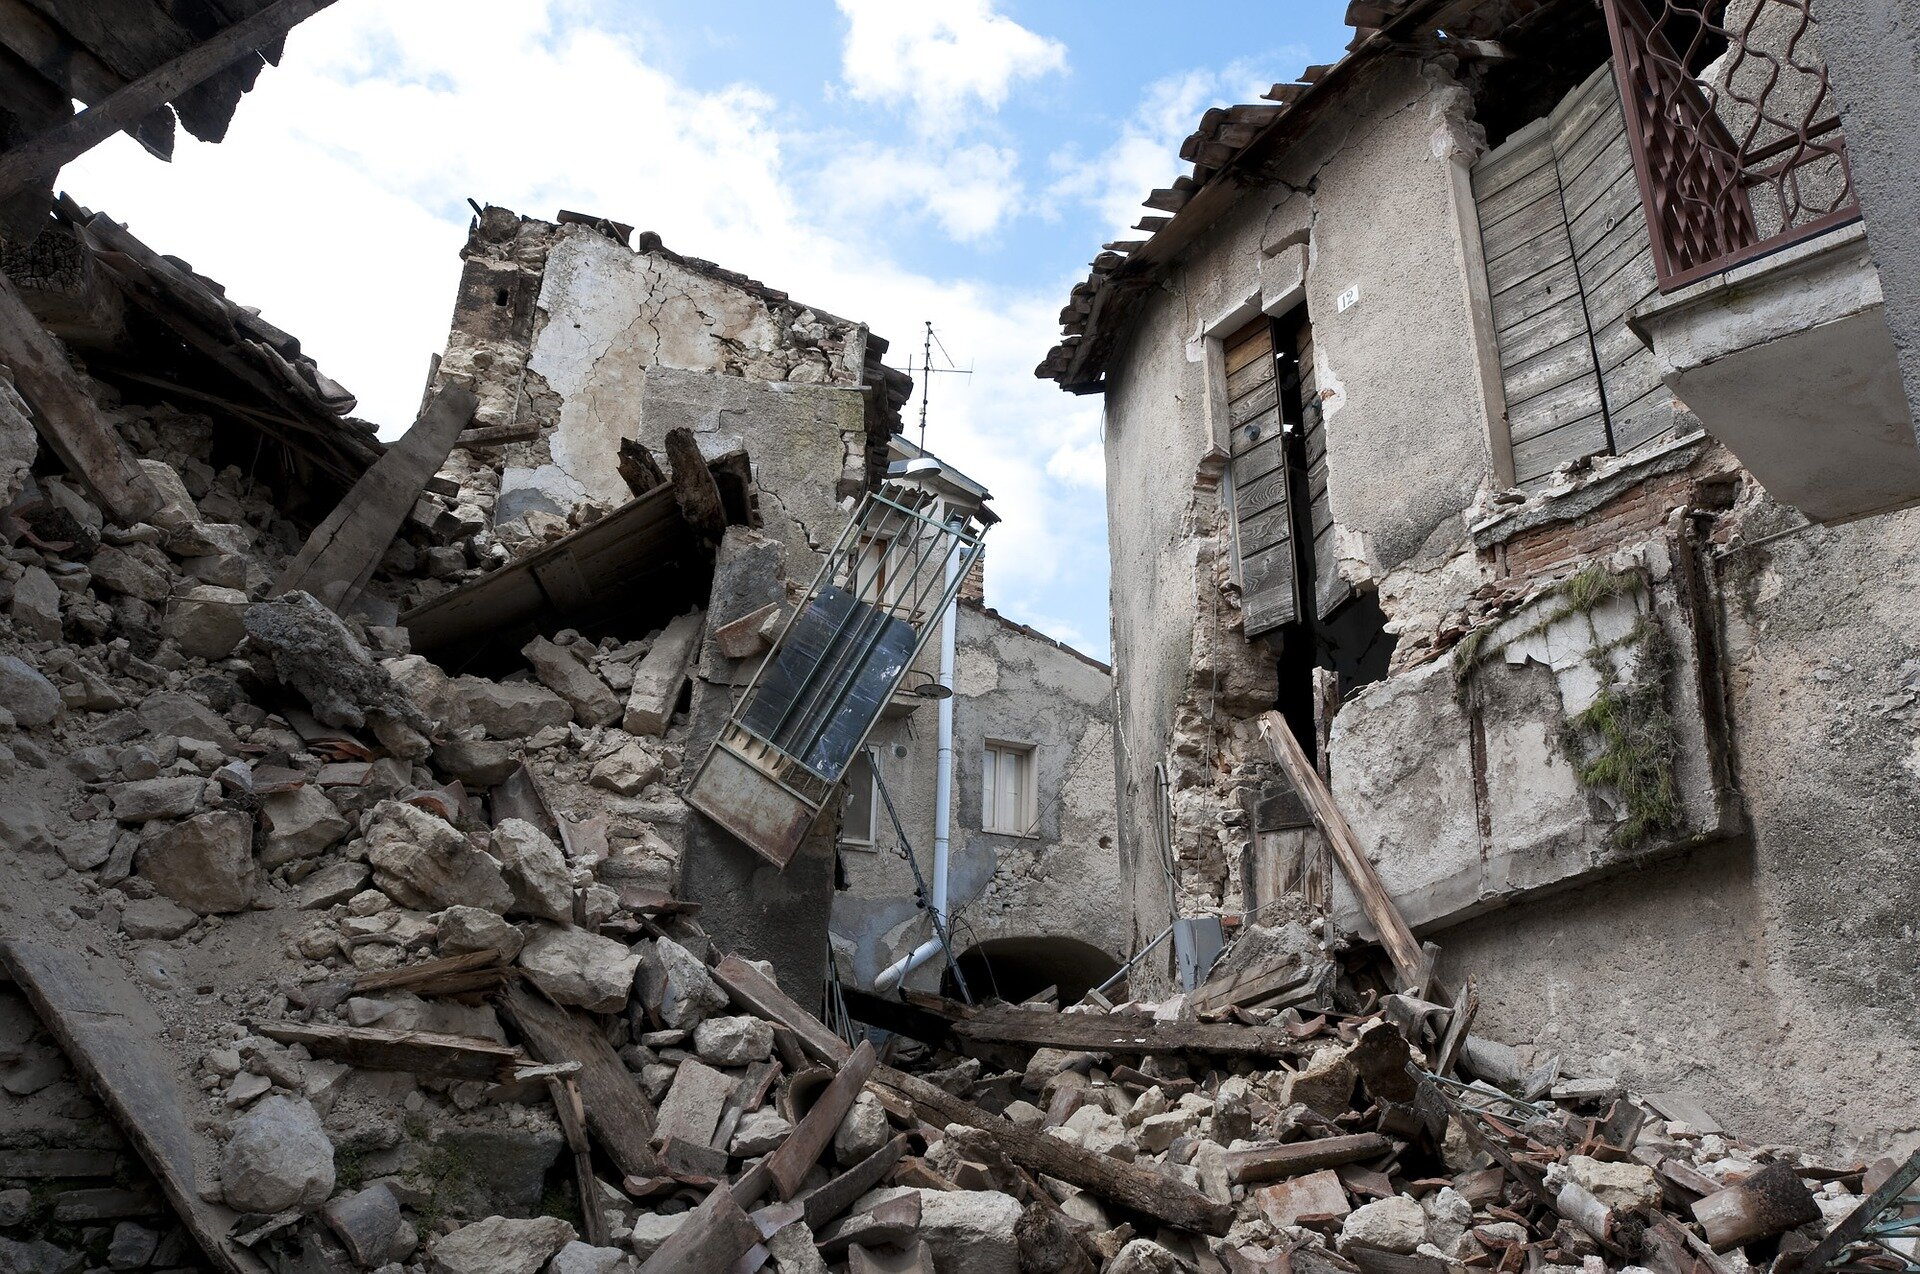

{'incident_probs': array([0.9908563 , 0.58951104, 0.10360007, 0.05463378, 0.03776054],
      dtype=float32),
 'incidents': ['earthquake',
               'collapsed',
               'damaged',
               'burned',
               'dirty contamined'],
 'place_probs': array([0.6154824 , 0.2629681 , 0.1339067 , 0.10749956, 0.09838304],
      dtype=float32),
 'places': ['building outdoor', 'house', 'slum', 'building facade', 'street']}


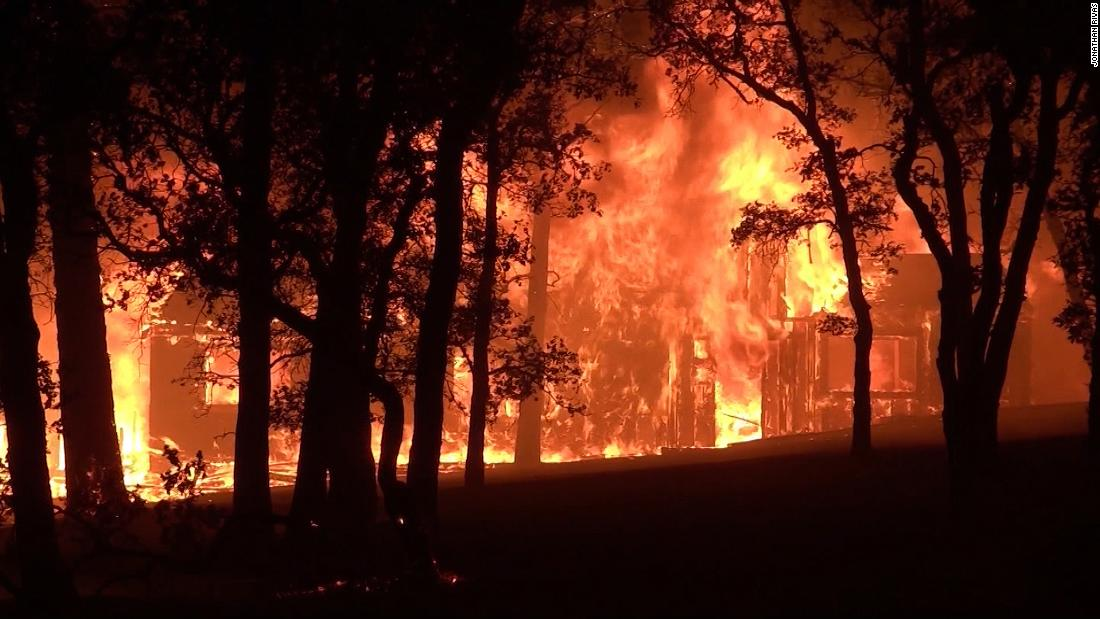

{'incident_probs': array([0.96481544, 0.9577678 , 0.588744  , 0.17603372, 0.04310583],
      dtype=float32),
 'incidents': ['wildfire', 'on fire', 'burned', 'fire whirl', 'fog'],
 'place_probs': array([0.9773218 , 0.13868007, 0.08294571, 0.06616325, 0.04356328],
      dtype=float32),
 'places': ['forest', 'forest road', 'house', 'building outdoor', 'park']}


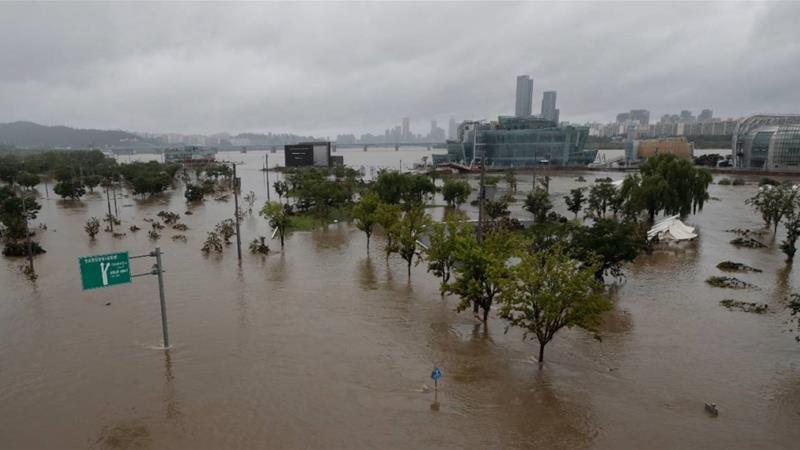

{'incident_probs': array([0.99733585, 0.8586756 , 0.31297264, 0.12871847, 0.02080395],
      dtype=float32),
 'incidents': ['flooded',
               'tropical cyclone',
               'heavy rainfall',
               'fog',
               'storm surge'],
 'place_probs': array([0.80692464, 0.46065295, 0.43182498, 0.25140902, 0.11504369],
      dtype=float32),
 'places': ['downtown',
            'building outdoor',
            'river',
            'skyscraper',
            'residential neighborhood']}


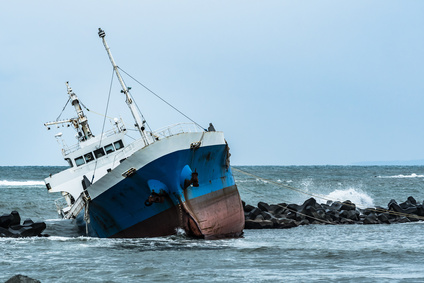

{'incident_probs': array([0.971289  , 0.06059635, 0.02194535, 0.01811273, 0.01312472],
      dtype=float32),
 'incidents': ['ship boat accident',
               'tropical cyclone',
               'fog',
               'damaged',
               'snow covered'],
 'place_probs': array([0.9563687 , 0.5924845 , 0.46718502, 0.2837917 , 0.01662633],
      dtype=float32),
 'places': ['ocean', 'beach', 'coast', 'port', 'river']}


In [ ]:
### SHOW RESULTS ###
from IPython.display import Image 
import PIL
for image_filename in inference_dict:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    display(PIL.Image.fromarray(img))
    pprint.pprint(inference_dict[image_filename])